# "Single-nucleus Multiomic Atlas of Frontal Cortex in ALS: A Deep Learning Approach"

This Jupyter notebook is dedicated to reproducing results from the paper:

> "Single-nucleus Multiomic Atlas of Frontal Cortex in Amyotrophic Lateral Sclerosis with a Deep Learning-based Decoding of Alternative Polyadenylation Mechanisms" by Paul M. Mckeever and Aiden M. Sababi (2023).

The paper presents a comprehensive analysis of single-nucleus multiomics in the context of amyotrophic lateral sclerosis (ALS), focusing on alternative polyadenylation mechanisms using deep learning techniques.

The primary objective of this notebook is to replicate key figures and findings from the study, providing a transparent and reproducible path for validation and further exploration.

The paper can be found [here](https://www.biorxiv.org/content/10.1101/2023.12.22.573083v1.full).


# Figure 4.

## A) APAlog volcano plots.

In [40]:
library(ggplot2)
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
library(ggridges)
library(ggrepel)

In [2]:
setwd('/PATH/Mapper_outs/')

In [6]:
volcano_plot_2 <- function(fit, x, xlab = "Ln fold change", y, ylab = "-Log10 FDR",
    title = "LMCN data, metastatic vs non-metastatic", titleLabSize = 12, border = "full",
    pCutoff = 0.001, FCcutoff = 1.5, xlim = c(-3, 3), ylim = c(0, 10), pointsize= .2, top_n) {

    if (! x %in% names(fit)){
        stop(print(paste('The column', x, 'does not exist in the given dataframe.')))
    }

    if (! y %in% names(fit)){
        stop(print(paste('The column', y, 'does not exist in the given dataframe.')))
    }

    return(EnhancedVolcano::EnhancedVolcano(fit, lab = fit['transcript'], selectLab=top_n, x=x, xlab=xlab, y=y, ylab=ylab, title=title,
    titleLabSize=titleLabSize, border=border, pCutoff=pCutoff, FCcutoff=FCcutoff, xlim=xlim, ylim=ylim, pointSize=pointsize))
}

adj_p <- function(x, pcols, adj_method){
    y <- x[, pcols, drop = FALSE]
    if (adj_method == "qvalue"){
        y <- apply(y, 2, function(t) qvalue::qvalue(t)$qvalues)
    } else {
        y <- apply(y, 2, function(t) stats::p.adjust(t, method = adj_method))
    }

    newnames <- paste0(adj_method, "_", colnames(y))
    z <- data.frame(x,y)
    colnames(z)[(NCOL(x)+1) : NCOL(z)] <- newnames
    return(z)
}

get_sig_threshold <- function(df){
    df <- df %>% arrange(fdr_p_ConditionALS_pathology)
    return(df[which(df$fdr_p_ConditionALS_pathology > 0.05),][1,]$p_ConditionALS_pathology)
}

# Function to generate and save volcano plot
generate_volcano_plot <- function(df, x_col, y_col, title, cutoff, fc_cutoff, ylim, point_size, top_n, output_path) {
    volcano_plot_2(df, x = x_col, y = y_col, title = title, pCutoff = cutoff, FCcutoff = fc_cutoff, ylim = ylim, pointsize = point_size, top_n = top_n)
    ggsave(output_path, width = 10, height = 10, units = "in", dpi = 300)
}

# Main processing loop for all celltypes and conditions
process_data_plot_APAusage <- function(sub_cts, data_root, output_dir) {
    for (ct in sub_cts) {
        print(ct)
        input_file <- paste0(data_root, ct, "/APAlog_res_metadata_added.tsv")
        inp_df <- read.csv(input_file, sep = '\t')
        
        # Adjust p-values
        inp_df <- adj_p(inp_df,pcols = 9, adj_method = "fdr")

        # Determine significance threshold
        sig_threshold <- get_sig_threshold(inp_df)
        
        # Generate and save volcano plot
        volcano_plot_title <- paste0('Volcano plot for ALS vs Control for ', ct)
        volcano_output_path <- paste0(data_root, output_dir, ct, '_volcano_plot.png')
        generate_volcano_plot(inp_df, 'LFC_PA_Usage', 'p_ConditionALS_pathology', volcano_plot_title, sig_threshold, .5, c(0, 10), 1, 0, volcano_output_path)

        # Update the sig_LFC_PA_Usage column
        inp_df$sig_LFC_PA_Usage_2 <- ifelse(inp_df$p_ConditionALS_pathology < 0.02 & abs(inp_df$LFC_PA_Usage) > 0.1, inp_df$LFC_PA_Usage, 0)
        
        # Save the updated dataframe
        output_file <- paste0(data_root, ct, "/APAlog_res_metadata_added_adj_pval.tsv")
        write.table(inp_df, file = output_file, quote = FALSE, sep = '\t', row.names = FALSE)
    }
}

In [7]:
data_root = "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/"
sub_cts <- list.dirs(data_root, recursive = F, full.names = F)
c9_als_sub_cts <- sub_cts[grep("C9ALSvsCTRL", sub_cts)]
s_als_sub_cts <- sub_cts[grep("sALSvsCTRL", sub_cts)]

# Excitatory_C9ALSvsCTRL Volcano Plot
![Excitatory_C9ALSvsCTRL Volcano Plot](/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/APAlog_APA_usage_volcanos/Excitatory_C9ALSvsCTRL_volcano_plot.png)

# Excitatory_sALSvsCTRL Volcano Plot
![Excitatory_sALSvsCTRL Volcano Plot](/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/APAlog_APA_usage_volcanos/Excitatory_sALSvsCTRL_volcano_plot.png)


# Figure 4 "a" and "b"

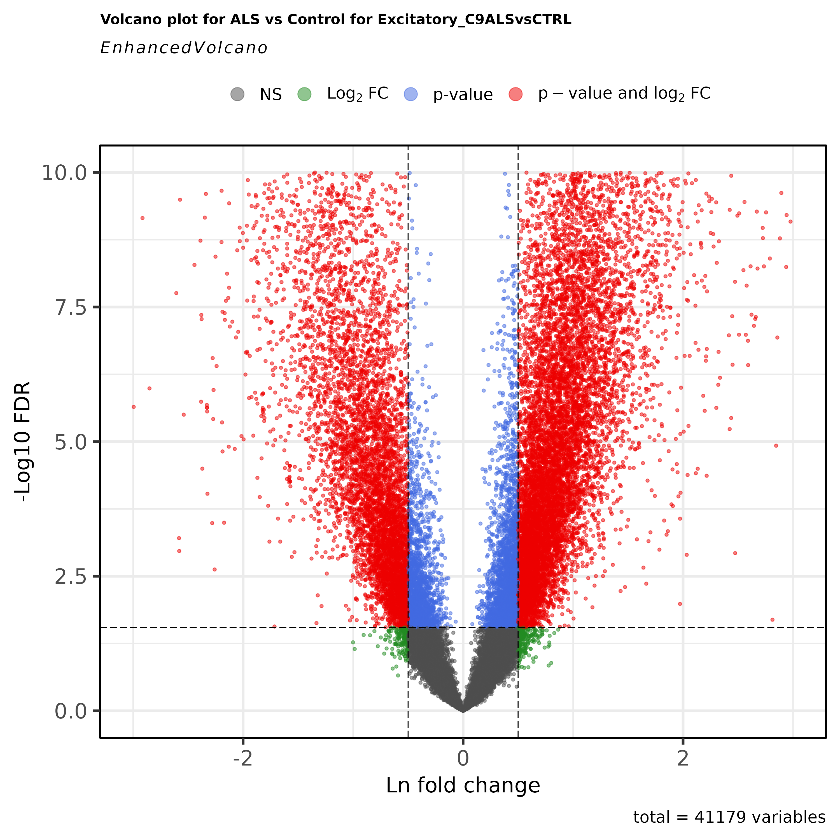

In [13]:
# Display Excitatory_C9ALSvsCTRL Volcano Plot
library(png)
library(grid)

img <- readPNG(paste0(data_root,'APAlog_APA_usage_volcanos/Excitatory_C9ALSvsCTRL_volcano_plot.png'))
grid.raster(img)


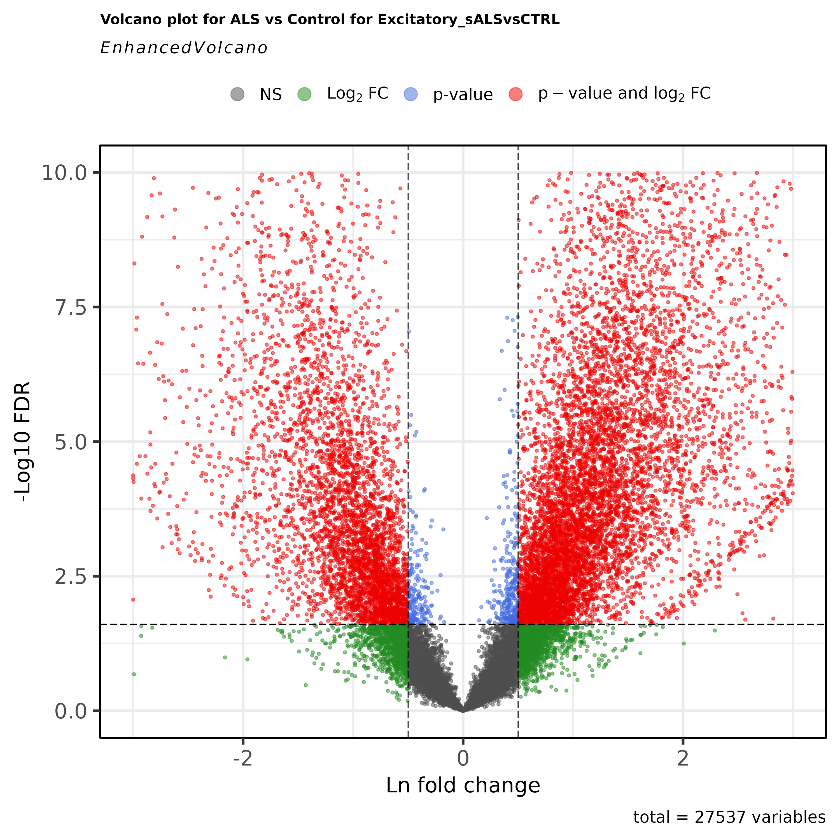

In [14]:
# Display Excitatory_sALSvsCTRL Volcano Plot
img <- readPNG(paste0(data_root,'APAlog_APA_usage_volcanos/Excitatory_sALSvsCTRL_volcano_plot.png'))
grid.raster(img)

# Figure 4, "c"

In [32]:
# Define a function to read data and filter cell types
read_and_filter_data <- function(file_path, cell_types) {
  df <- read.csv(file_path)
  df <- df[df$celltype %in% cell_types,]
  df$celltype <- factor(df$celltype, levels = cell_types)
  df$celltype = gsub('_sALSvsCTRL', '', df$celltype)
  df$celltype = gsub('_C9ALSvsCTRL', '', df$celltype)
  return(df)
}

# Define a function to create ridge plot
create_ridge_plot <- function(df, title, color) {
  df %>% 
    mutate(celltype = factor(celltype, levels = rev(c("OPC", "Oligodendrocytes", "Microglia", "Astrocytes", "Excitatory", "Inhibitory")))) %>%
    ggplot(aes(x = APA_LFC, y = celltype, fill = 0.5 - abs(0.5 - stat(ecdf)))) +
    stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE) +
    scale_fill_gradient(low = "white", high = color, name = "Tail prob.") +
    facet_grid(celltype ~ ., scales = "free") + 
    labs(title = title, x = "APA_LFC", y = "Celltype") +
    theme_bw() +
    theme(
      plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
      axis.title.x = element_text(size = 16),
      axis.title.y = element_text(size = 16),
      strip.text = element_text(size = 16, face = "bold"),
      legend.title = element_text(size = 12),
      legend.text = element_text(size = 12)
    )
}

# Main cell types
main_celltypes = c('Microglia_C9ALSvsCTRL', 'Inhibitory_C9ALSvsCTRL', 'Excitatory_C9ALSvsCTRL',
 'Astrocytes_C9ALSvsCTRL', 'OPC_C9ALSvsCTRL', 'Oligodendrocytes_C9ALSvsCTRL',
 'Microglia_sALSvsCTRL', 'Inhibitory_sALSvsCTRL', 'Excitatory_sALSvsCTRL', 
 'Astrocytes_sALSvsCTRL', 'OPC_sALSvsCTRL', 'Oligodendrocytes_sALSvsCTRL')
# Read and process data
C9ALS_df <- read_and_filter_data('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_type_dist_allCTs.csv', main_celltypes)
sALS_df <- read_and_filter_data('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/apa_sALS_type_dist_allCTs.csv', main_celltypes)


Picking joint bandwidth of 0.146

Picking joint bandwidth of 0.182

Picking joint bandwidth of 0.093

Picking joint bandwidth of 0.157

Picking joint bandwidth of 0.0741

Picking joint bandwidth of 0.115



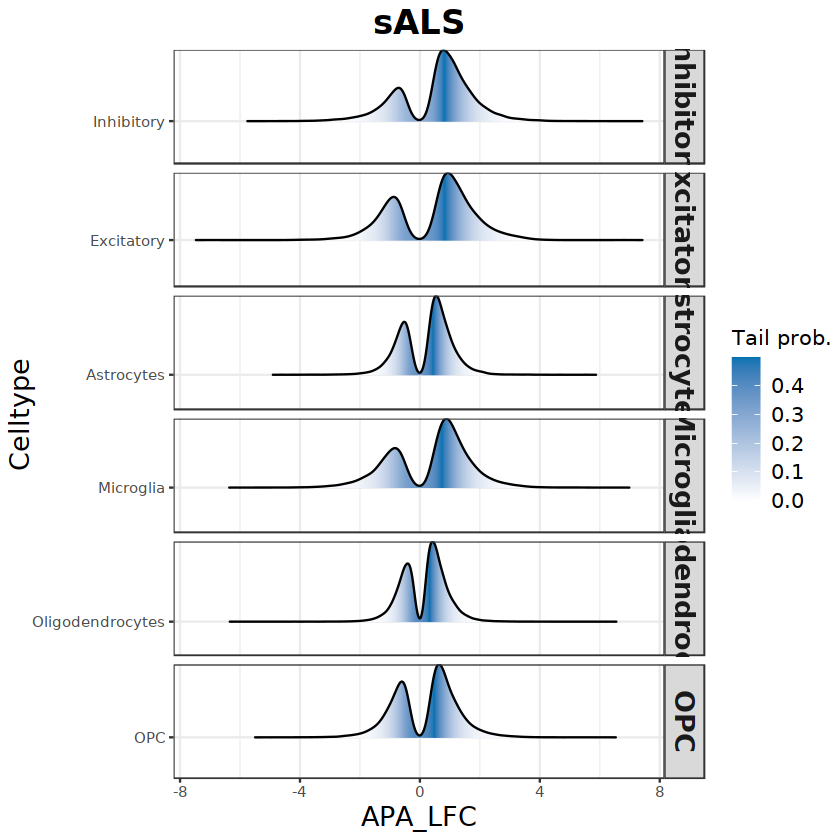

In [34]:
ridge_plot_sALS <- create_ridge_plot(sALS_df, 'sALS', '#0072B2')
ridge_plot_sALS

Picking joint bandwidth of 0.102

Picking joint bandwidth of 0.115

Picking joint bandwidth of 0.0736

Picking joint bandwidth of 0.155

Picking joint bandwidth of 0.0551

Picking joint bandwidth of 0.105



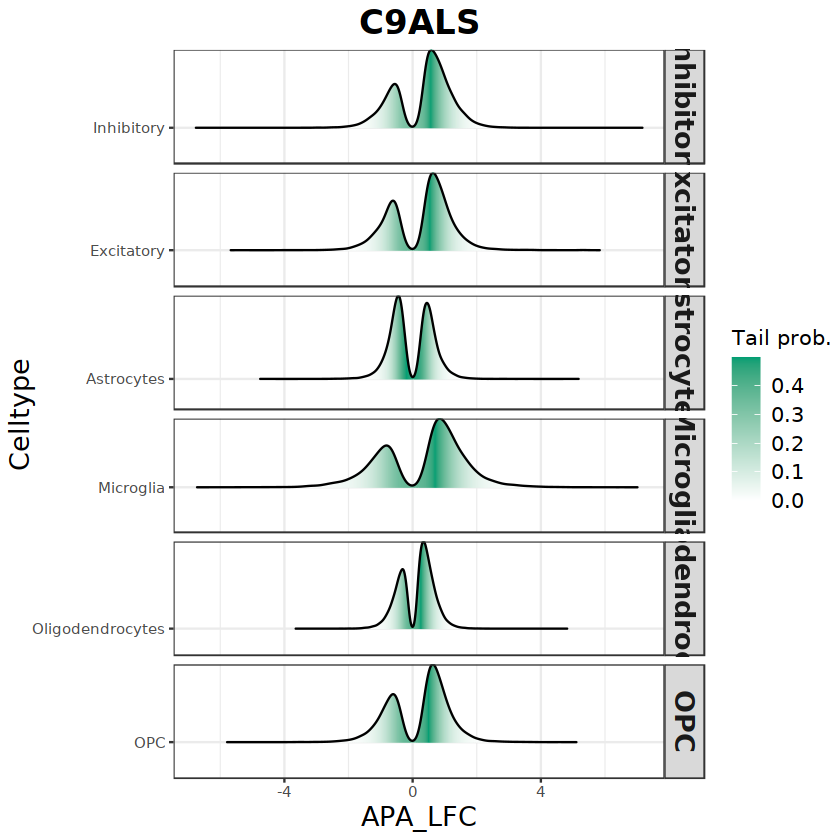

In [35]:
ridge_plot_C9ALS <- create_ridge_plot(C9ALS_df, 'C9ALS', '#009E73')
ridge_plot_C9ALS

# Figure 4, "d"

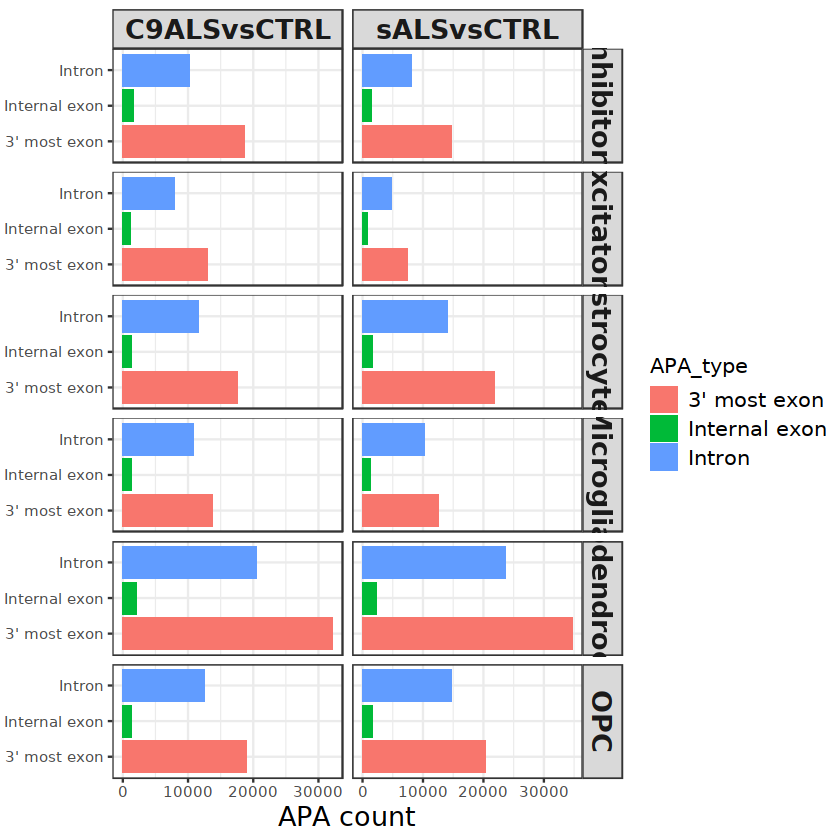

In [36]:
C9ALS_df$condition <- 'C9ALSvsCTRL'
sALS_df$condition <- 'sALSvsCTRL'

combined_df <- rbind(C9ALS_df, sALS_df)

combined_df <- combined_df %>% mutate(celltype = fct_relevel(celltype, rev(c("OPC", "Oligodendrocytes", "Microglia", "Astrocytes", "Excitatory", "Inhibitory"))))

combined_df %>% filter(APA_type %in% c("3' most exon", 'Internal exon', "Intron")) %>%
  ggplot(aes(y = APA_type, fill = APA_type)) + 
  geom_bar() +
  facet_grid(celltype  ~ condition , scales = "free") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = 'APA count', y = NULL, title = NULL) +
  theme(legend.position = "bottom") +
   theme_bw() +
  theme(
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    strip.text = element_text(size = 16, face = "bold"),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12)
  )

# Figure 4, "e" and "f"
### Extended Data Figure 5 plots

In [76]:
volcano_plot_func_REDi<- function(df) {
  df$REDi.pval.adj <- p.adjust(df$REDi.pval, method = "fdr")
  df <- df[!is.na(df$REDi),]
  threshold <- 0.01 
  # find the p-value at REDi.pval.adj < 0.01, this is where we will draw the line
  significance_threshold <- df[df$REDi.pval.adj < threshold,] %>% arrange(desc(REDi.pval.adj)) %>% head(1)
  # get value of 'REDi.pval.adj'
  significance_threshold = significance_threshold$REDi.pval
  # Filter out rows where -log10pval is greater than 50 and where REDi is less than -5 or more than 5
  df$neglog10pval <- -log10(df$REDi.pval)
  df <- df[!df$neglog10pval > 50 & df$REDi > -5 & df$REDi < 5,]
  # Add a significance column based on p-value
  df$significant <- ifelse(df$REDi.pval < significance_threshold, "Significant", "Not Significant")

  # Further categorize based on log2FC
  df$significant <- ifelse(df$significant == "Significant" & abs(df$REDi) > 1, "Significant", "Not Significant")

  # Add a category for lengthened and shortened
  df$transcript_length <- ifelse(df$REDi > 0 & df$significant == "Significant", "Shortened", 
                                 ifelse(df$REDi < 0 & df$significant == "Significant", "Lengthened", "Not Significant"))

  # ALS genes to include in the plot
  ALSgenes <- c("TARDBP","C9orf72","SOD1","FUS","NEK1","OPTN","CHCHD10","SQSTM1",
  "TBK1","KIF5A","SETX","UBQLN2","MATR3","VAPB","SIGMAR1","ANXA11",
  "TUBA4A","ALS2","GRN","PFN1","CHMP2B","TIA1","ANG","SPAST","FIG4",
  "SPG11","GLE1","CCNF","ATXN2","VCP", "STMN2", "UNC13A")
  
  # Create a subset of df for top 100 most significant genes and include ALS genes
  # Create a subset of df for top 10 most significant and lengthened genes and top 10 most significant and shortened genes
  top20_lengthened <- df[df$transcript_length == "Lengthened",] %>% arrange(REDi) %>% head(10)
  top20_shortened <- df[df$transcript_length == "Shortened",] %>% arrange(desc(REDi)) %>% head(10)
  interested_genes_df <- df[df$gene %in% ALSgenes,]
  # keep significant genes in interested_genes_df
  interested_genes_df <- interested_genes_df[interested_genes_df$significant == "Significant",]
  top_40 <- rbind(top20_lengthened, top20_shortened, interested_genes_df)
  # remove the NA from df based on REDi
  df <- df[!is.na(df$REDi),]

  # Plot the volcano plot
  volcano_plot <- ggplot(df, aes(x=-1*REDi, y=neglog10pval, color=transcript_length)) +
      geom_point(alpha=1, size=2) + 
      scale_color_manual(values=c("#CC79A7", "grey", "#F0E442"), labels=c("Lengthened", "Not Significant", "Shortened"), name = "Transcript Length") +
      theme_bw(base_size = 14) +  
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "bottom",
            legend.box = "vertical",
            legend.title = element_text(size = 14, face='bold' ),  # Adjust legend text size here
            legend.text = element_text(size = 12),  # Adjust legend text size here
            plot.title = element_text(hjust = 0.5)) +
            guides(color=guide_legend(override.aes=list(size=6))) +
      xlab('REDi') + 
      ylab('-log10pval') + 
      geom_text_repel(data = top_40, aes(label = gene), size = 3.5, color='black') + 
      geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey", alpha = 0.8) +
      geom_hline(yintercept = -log10(significance_threshold), linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-7, 7), ylim=c(0,50)) # restrict x-axis and y-axis limits

  return(volcano_plot)
}



volcano_plot_func_REDu <- function(df) {
  df$REDu.pval.adj <- p.adjust(df$REDu.pval, method = "fdr")
  df <- df[!is.na(df$REDu),]
  threshold <- 0.01 
  # find the p-value at REDu.pval.adj < 0.01, this is where we will draw the line
  significance_threshold <- df[df$REDu.pval.adj < threshold,] %>% arrange(desc(REDu.pval.adj)) %>% head(1)
  # get value of 'REDu.pval.adj'
  significance_threshold = significance_threshold$REDu.pval
  # Filter out rows where -log10pval is greater than 50 and where REDu is less than -5 or more than 5
  df$neglog10pval <- -log10(df$REDu.pval)
  df <- df[!df$neglog10pval > 50 & df$REDu > -5 & df$REDu < 5,]
  # Add a significance column based on p-value
  df$significant <- ifelse(df$REDu.pval < significance_threshold, "Significant", "Not Significant")

  # Further categorize based on log2FC
  df$significant <- ifelse(df$significant == "Significant" & abs(df$REDu) > 1, "Significant", "Not Significant")

  # Add a category for lengthened and shortened
  df$transcript_length <- ifelse(df$REDu > 0 & df$significant == "Significant", "Shortened", 
                                 ifelse(df$REDu < 0 & df$significant == "Significant", "Lengthened", "Not Significant"))

  # ALS genes to include in the plot
  ALSgenes <- c("TARDBP","C9orf72","SOD1","FUS","NEK1","OPTN","CHCHD10","SQSTM1",
  "TBK1","KIF5A","SETX","UBQLN2","MATR3","VAPB","SIGMAR1","ANXA11",
  "TUBA4A","ALS2","GRN","PFN1","CHMP2B","TIA1","ANG","SPAST","FIG4",
  "SPG11","GLE1","CCNF","ATXN2","VCP", "STMN2", "UNC13A")
  
  # Create a subset of df for top 100 most significant genes and include ALS genes
  # Create a subset of df for top 10 most significant and lengthened genes and top 10 most significant and shortened genes
  top20_lengthened <- df[df$transcript_length == "Lengthened",] %>% arrange(REDu) %>% head(10)
  top20_shortened <- df[df$transcript_length == "Shortened",] %>% arrange(desc(REDu)) %>% head(10)
  interested_genes_df <- df[df$gene %in% ALSgenes,]
  # keep significant genes in interested_genes_df
  interested_genes_df <- interested_genes_df[interested_genes_df$significant == "Significant",]
  top_40 <- rbind(top20_lengthened, top20_shortened, interested_genes_df)
  # remove the NA from df based on REDu
  df <- df[!is.na(df$REDu),]

  # Plot the volcano plot
  volcano_plot <- ggplot(df, aes(x=-1*REDu, y=neglog10pval, color=transcript_length)) +
      geom_point(alpha=1, size=2) + 
      scale_color_manual(values=c("#CC79A7", "grey", "#F0E442"), labels=c("Lengthened", "Not Significant", "Shortened"), name = "Transcript Length") +
      theme_bw(base_size = 14) +  
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "bottom",
            legend.box = "vertical",
            legend.title = element_text(size = 14, face='bold' ),  # Adjust legend text size here
            legend.text = element_text(size = 12),  # Adjust legend text size here
            plot.title = element_text(hjust = 0.5)) +
            guides(color=guide_legend(override.aes=list(size=6))) +
      xlab('REDu') + 
      ylab('-log10pval') + 
      geom_text_repel(data = top_40, aes(label = gene), size = 3.5, color='black') + 
      geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey", alpha = 0.8) +
      geom_hline(yintercept = -log10(significance_threshold), linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-7, 7), ylim=c(0,50)) # restrict x-axis and y-axis limits

  return(df)
}

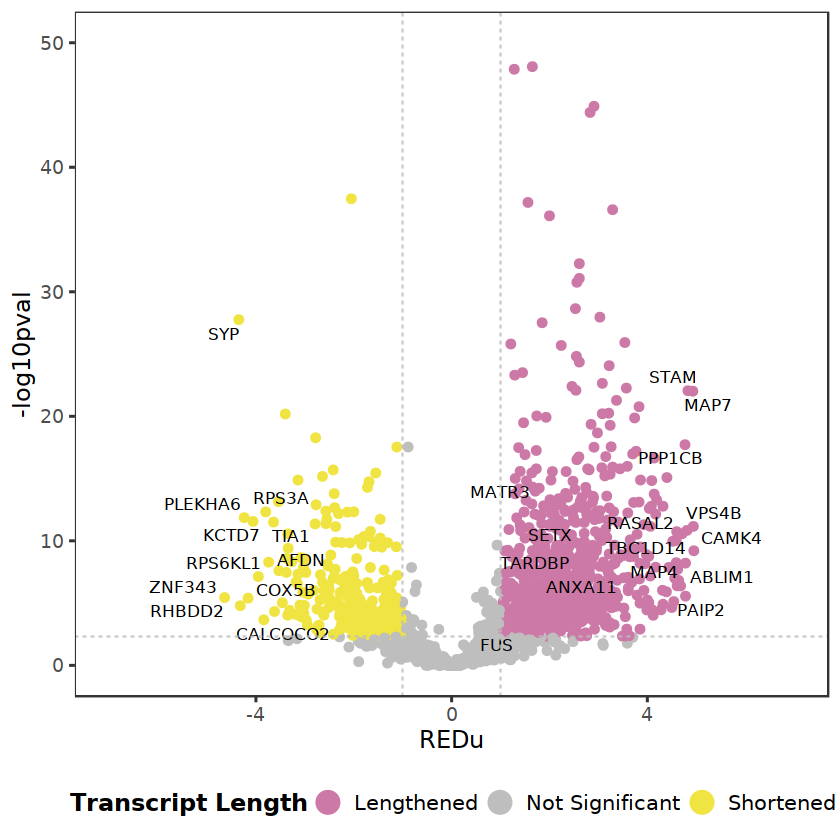

In [67]:
df = read.table(paste0(data_root, 'Excitatory_sALSvsCTRL/gene.txt'), sep='\t', header=T)
plot <- volcano_plot_func_REDu(df)
print(plot)

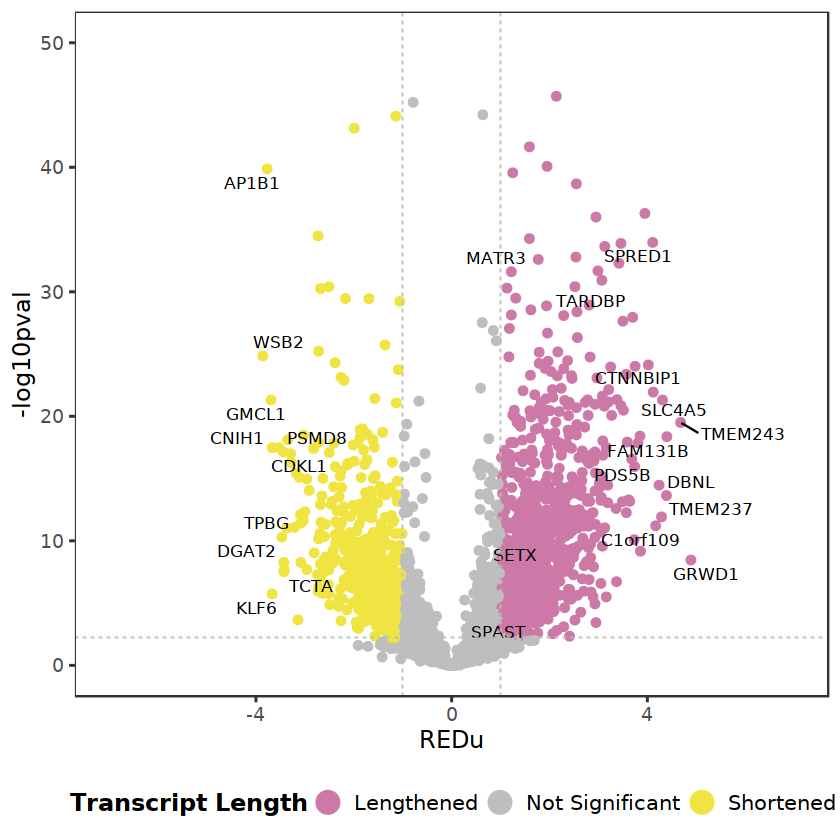

In [65]:
df = read.table(paste0(data_root, 'Excitatory_C9ALSvsCTRL/gene.txt'), sep='\t', header=T)
plot <- volcano_plot_func_REDu(df)
print(plot)